# Niave Composite Solve

This script will attempt to solve the system of equations on the composite medium (dielectric plus dielectic inclusions) for the cross-in-plane geometry example.
The domain is $\Omega = \left[0,1\right]^2$ with periodic boundary conditions.
The quasi-momentum $\theta$ is fixed for each problem.
The singular inclusions are the quantum graph $\mathbb{G}$ which consists of vertices and edges
\begin{align*}
    v_1 = (0.5,1.0), \quad v_2 = (0.0,0.5), \quad v_3 &= (0.5,0.5), \quad v_4 = (1.0,0.5), \quad v_5 = (0.5,0.0), \\
    l_{23} = l_{34} = & l_{53} = l_{31} = 0.5, \\
    \theta_{23} = \theta_{34} = \theta_1, &\quad \theta_{53} = \theta_{31} = \theta_2.
\end{align*}
The graph divides $\Omega$ into four regions (although in reality it's only one region by the periodic BCs) which we label $\Omega_i$ for $i=1,2,3,4$; ordered counterclockwise as 1 (bottom left), 2 (top left), 3 (top right) and 4 (bottom right).

This will be done through a niave finite-difference approximation to the operator that acts on each part of the domain.
The equations to solve are:
\begin{align*}
    -\Delta_{\theta}u &= -\omega^2 u, \qquad x\in\Omega_i, \\
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} &= \omega^2 u_{jk} + \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right), \qquad x\in I_{jk}, \\
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk} &= \alpha_3\omega^2 u(v_3), \qquad x=v_3.
\end{align*}
__NOTE:__ We haven't done the analysis for when $\alpha_j\neq0$ for the composite measure, but without $\alpha_3$ I don't see how to setup the FDM such that it has full rank.
Try experimenting with what's happening here Will!

We must first discretise our domain into a (for ease, uniform) $N\times N$ grid.
Since we _need_ meshpoints on the graph itself, it will be convenient for us to take $N$ odd, so that the points can be generated via `linspace`.
Set $h = \frac{1}{N}$ as the mesh width, and for each $i,j\in\{1,...,N\}$ we define $u_{i,j} = u(ih, jh)$.
We must now discretise our operators, after which we find that
\begin{align*}
    -\Delta_{\theta}u_{i,j} &\approx
    \lvert\theta\rvert^2 u_{i,j} 
    - 2\mathrm{i}h^{-1}\left[ \theta_1\left( u_{i-1,j} + u_{i+1,j} - 2u_{i,j} \right) + \theta_2\left( u_{i,j-1} + u_{i,j+1} - 2u_{i,j} \right) \right]
    + h^{-2}\left[ 4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1} \right], \\
    &= \left(\lvert\theta\rvert^2 + 4\mathrm{i}h^{-1}(\theta_1+\theta_2) + 4h^{-2}\right)u_{i,j}
    - \left(2\mathrm{i}h^{-1}\theta_1 + h^{-2} \right)(u_{i-1,j} + u_{i+1,j})
    - \left(2\mathrm{i}h^{-1}\theta_2 + h^{-2} \right)(u_{i,j-1} + u_{i,j-1})
\end{align*}
in any region $\Omega_i$.
For horizontal edges ($I_{23}$ and $I_{34}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i-1,j} - u_{i+1,j} \right) - h^{-1}\left[ u_{i,j+1} - u_{i,j-1} - 2\mathrm{i}\theta_{jk}\left(u_{i+1,j} - u_{i,j} \right) \right],
\end{align*}
whilst for vertical edges ($I_{53}$ and $I_{31}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i,j-1} - u_{i,j+1} \right) - h^{-1}\left[ u_{i+1,j} - u_{i-1,j} - 2\mathrm{i}\theta_{jk}\left(u_{i,j+1} - u_{i,j} \right) \right].
\end{align*}
Note the interaction between of the regions either side of an edge as $\Omega^+$ and $\Omega^-$ are chosen in the derivation document ($\Omega^+$ is in the positive $n_{jk}$ direction off $I_{jk}$), combined with how our gridpoints are labelled ($i,j$ increase up and to the right respectively).
Finally, at $v_3$ it is best if we explicitly write down what the sum reduces to:
\begin{align*}
    0 &= h^{-1}\left( u_{i-1,j} - u_{i+1,j} + u_{i,j-1} - u_{i,j+1} \right)
\end{align*}

It is now time to assemble the Finite Difference Matrix (FDM) for the problem above.
We will elect to store the points $u_{i,j}$ column-wise, so we acquire a vector
\begin{align*}
    U = \begin{pmatrix} u_{0,0} \\ u_{0,1} \\ \vdots \\ u_{0,N} \\ u_{1,0} \\ u_{1,1} \\ \vdots \end{pmatrix},
\end{align*}
and running `U.resize((N,N))` will then produce an $N\times N$ matrix whose $ij$-th entry is $u_{i,j}$.
To this end, we can translate as follows;
\begin{align*}
    u_{i,j} = U[j + N*i],
\end{align*}
for any $i,j\in\{1,...,N\}$.

In [1]:
# imports
import numpy as np
from scipy.linalg import eig

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# number of meshpoints
N = 25
if N%2==0:
    print('N = %d is not even, using N=%d instead' % (N, N+1))
    N += 1
# mesh width
h = 1./N

# quasi-momentum value
theta = np.array([np.pi/4,0.], dtype=float)
# coupling constant at v_3
alpha3 = 0.0

# gridpoint placements
x = y = np.linspace(0.,1.,num=N)

# basic functions
def M2C(i,j):
    '''
    Provides the column index in U for the gridpoint u_{i,j}.
    INPUTS:
        i,j: int, gridpoint indices
    OUTPUTS:
        c: int, index such that U[c] = u_{i,j}
    '''
    
    return j + N*i

def PlotFn(N, U, levels=10):
    '''
    Create contour plots for the eigenfunction U that is passed in.
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: (N*N,) complex, column vector of eigenfunction values at meshpoints
        levels: (optional) int - default 10, number of contour levels to pass to contourf.
    OUTPUTS:
        Two lists of the form [fig, ax] for the handles of the matplotlib figures,
        the first containing the plot of the real part of U and 
        the second containing the plot of the imaginary part of U.
    '''
    
    # gridpoints used
    x = y = np.linspace(0,1, num=N)
    # plot handles
    rFig, rAx = plt.subplots()
    iFig, iAx = plt.subplots()
    # axis setup
    for a in [rAx, iAx]:
        a.set_aspect('equal')
        a.set_xlabel(r'$x_1$')
        a.set_ylabel(r'$x_2$')
    rAx.set_title(r'$\Re (u)$')
    iAx.set_title(r'$\Im (u)$')
    
    # if more levels than meshpoints in each dimension, could be difficult! Throw a warning
    if levels >= N:
        print('Number of contour levels exceeds or equals N!')
    # make contour plots
    rCon = rAx.contourf(x, y, np.real(U.reshape((N,N))), levels=levels)
    iCon = iAx.contourf(x, y, np.imag(U.reshape((N,N))), levels=levels)
    # make colourbars
    rFig.colorbar(rCon)
    iFig.colorbar(iCon)
    
    return [rFig, rAx], [iFig, iAx]

## Assembling the FDM

`x[N//2]` and `y[N//2]` correspond to 0.5 exactly, and are where the graph is placed.
The meshpoints which fall into each region $\Omega_i$ are now easily collected:
- $\Omega_1$ (bottom left) `x[:N//2]` and `y[:N//2]`,
- $\Omega_2$ (top left) `x[:N//2]` and `y[N//2+1:]`,
- $\Omega_3$ (top right) `x[N//2+1:]` and `y[N//2+1:]`,
- $\Omega_4$ (bottom right) `x[N//2+1:]` and `y[:N//2]`.

The graph edges are also easily collated now:
- $I_{31}$: `x[N//2]` and `y[N//2+1:]`,
- $I_{53}$: `x[N//2]` and `y[:N//2]`,
- $I_{23}$: `x[:N//2]` and `y[N//2]`,
- $I_{34}$: `x[N//2+1:]` and `y[N//2]`,

and of course, $v_3$ lies at `x[N//2],y[N//2]`.

For a gridpoint $i,j$ in one of the regions $\Omega_i$, we now build the FDM rows that correspond to the equation at that gridpoint.
Recall that
\begin{align*}
    -\Delta_{\theta}u_{i,j} &\approx
    \left(\lvert\theta\rvert^2 + 4\mathrm{i}h^{-1}(\theta_1+\theta_2) + 4h^{-2}\right)u_{i,j}
    - \left(2\mathrm{i}h^{-1}\theta_1 + h^{-2} \right)(u_{i-1,j} + u_{i+1,j})
    - \left(2\mathrm{i}h^{-1}\theta_2 + h^{-2} \right)(u_{i,j-1} + u_{i,j-1})
\end{align*}

In [2]:
def RegionalFDM(M, region, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j in the region Omega_region.
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        region: int, 1-4 specifying which region to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the region Omega_region will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    # Compute some common constants first
    h = 1./N
    sqMagTheta = theta[0]*theta[0] + theta[1]*theta[1]
    sumTheta = np.sum(theta)
    
    # determine correct indices to loop over via lookup
    if region==1:
        jR = range(N//2)
        iR = range(N//2)
    elif region==2:
        jR = range(1+N//2,N)
        iR = range(N//2)
    elif region==3:
        jR = range(1+N//2,N)
        iR = range(1+N//2,N)
    elif region==4:
        jR = range(N//2)
        iR = range(1+N//2,N)
    else:
        raise ValueError('Unrecognised region, got %d' % (region))
        
    # now insert the entries of the FDM for the given region
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    if log:
        for j in jR:
            for i in iR:
                # this is the row that we are going to set
                Mrow = M2C(i,j)
                # u_{i,j} prefactor is placed on the diagonal
                M[Mrow, Mrow] = sqMagTheta + 4.j*sumTheta/h + 4/(h*h)
                # now place u_{i-1,j} and u_{i+1,j} prefactors
                # take index modulo N, since if you're on the periodic boundary you need to 
                # loop to the other side of the domain
                iLeft = (i-1) % N
                iRight = (i+1) % N
                leftIndex = M2C(iLeft, j)
                rightIndex = M2C(iRight, j)
                M[Mrow, leftIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                M[Mrow, rightIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
                jUp = (j+1) % N
                jDown = (j-1) % N
                upIndex = M2C(i,jUp)
                downIndex = M2C(i,jDown)
                M[Mrow, upIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
                M[Mrow, downIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
                # this completes the construction of this row of the FDM, we now have that
                # FDM[Mrow,:] * U[Mrow] defines the expression for -\Laplacian_{\theta} at i,j.
                print('---')
                print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
                print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
        print('Finished region: %d' % (region))
    else:
        for j in jR:
            for i in iR:
                Mrow = M2C(i,j)
                M[Mrow, Mrow] = sqMagTheta + 4.j*sumTheta/h + 4/(h*h)
                
                iLeft = (i-1) % N
                iRight = (i+1) % N
                leftIndex = M2C(iLeft, j)
                rightIndex = M2C(iRight, j)
                M[Mrow, leftIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                M[Mrow, rightIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                
                jUp = (j+1) % N
                jDown = (j-1) % N
                upIndex = M2C(i,jUp)
                downIndex = M2C(i,jDown)
                M[Mrow, upIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
                M[Mrow, downIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
    return

For horizontal edges ($I_{23}$ and $I_{34}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_1 \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i-1,j} - u_{i+1,j} \right) - h^{-1}\left[ u_{i,j+1} - u_{i,j-1} - 2\mathrm{i}\theta_1\left(u_{i+1,j} - u_{i,j} \right) \right],
\end{align*}
since $\theta_{jk}=\theta_1$ on horizontal edges.
For ease, we can rearrange this to be
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_1 \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    2h^{-1}(h^{-1}-\mathrm{i}\theta_1)u_{i,j} 
    - h^{-2}u_{i-1,j}
    + h^{-1}(2\mathrm{i}\theta_1 - h^{-1})u_{i+1,j}
    - h^{-1}u_{i,j+1}
    + h^{-1}u_{i,j-1}
\end{align*}
We can now construct the rows of the FDM corresponding to the horizontal edges.

In [3]:
def HorEdgeFDM(M, edge, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j on the edge I_{edge}
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        edge: int, either 23 or 34, specifying which horizontal edge to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the edge I_{edge} will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    h = 1./N
    # setup loop ranges based on the edge we are working on
    if edge==23:
        iR = range(N//2)
    elif edge==34:
        iR = range(1+N//2,N)
    else:
        raise ValueError('Unknown horizontal edge, got %d' % (edge))
    j = N//2 # j is constant for horizontal edges
    
    # now insert the entries of the FDM for the given edge
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    if log:
        for i in iR:
            # get row index
            Mrow = M2C(i,j)
            # u_{i,j} prefactor is placed on the diagonal
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[0])
            # now place u_{i-1,j} and u_{i+1,j} prefactors
            # take index modulo N, since if you're on the periodic boundary you need to 
            # loop to the other side of the domain
            iLeft = (i-1) % N
            iRight = (i+1) % N
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = - 1./(h*h)
            M[Mrow, rightIndex] = - 1./(h*h) + 2.j*theta[0]/h
            # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
            jUp = (j+1) % N
            jDown = (j-1) % N
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = -1./h
            M[Mrow, downIndex] = 1./h
            # this completes the construction of this row of the FDM, we now have that
            # FDM[Mrow,:] * U[Mrow] defines the expression for the edge operator at i,j.
            print('---')
            print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
            print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
        print('Finished edge: I_%d' % (edge))
    else:
        for i in iR:
            Mrow = M2C(i,j)
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[0])
            
            iLeft = (i-1) % N
            iRight = (i+1) % N
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = - 1./(h*h)
            M[Mrow, rightIndex] = - 1./(h*h) + 2.j*theta[0]/h
            
            jUp = (j+1) % N
            jDown = (j-1) % N
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = -1./h
            M[Mrow, downIndex] = 1./h      
    return

For the vertical edges ($I_{53}$ and $I_{31}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i,j-1} - u_{i,j+1} \right) - h^{-1}\left[ u_{i+1,j} - u_{i-1,j} - 2\mathrm{i}\theta_{jk}\left(u_{i,j+1} - u_{i,j} \right) \right],
\end{align*}
which we can re-write as
\begin{align*}
        -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    2h^{-1}(h^{-1} - \mathrm{i}\theta_2)u_{i,j}
    - h^{-2}u_{i,j-1}
    + h^{-1}(2\mathrm{i}\theta_2 - h^{-1})u_{i,j+1}
    - h^{-1}u_{i+1,j}
    + h^{-1}u_{i-1,j}.
\end{align*}

In [4]:
def VerEdgeFDM(M, edge, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j on the edge I_{edge}
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        edge: int, either 31 or 53, specifying which vertical edge to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the edge I_{edge} will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    h = 1./N
    # setup loop ranges based on the edge we are working on
    if edge==53:
        jR = range(N//2)
    elif edge==31:
        jR = range(1+N//2,N)
    else:
        raise ValueError('Unknown vertical edge, got %d' % (edge))
    i = N//2 # i is constant for vertical edges
    
    # now insert the entries of the FDM for the given edge
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    if log:
        for j in jR:
            # get row index
            Mrow = M2C(i,j)
            # u_{i,j} prefactor is placed on the diagonal
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[1])
            # now place u_{i-1,j} and u_{i+1,j} prefactors
            # take index modulo N, since if you're on the periodic boundary you need to 
            # loop to the other side of the domain
            iLeft = (i-1) % N
            iRight = (i+1) % N
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = 1./h
            M[Mrow, rightIndex] = - 1./h
            # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
            jUp = (j+1) % N
            jDown = (j-1) % N
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = - 1./(h*h) + 2.j*theta[1]/h
            M[Mrow, downIndex] = -1./(h*h)
            # this completes the construction of this row of the FDM, we now have that
            # FDM[Mrow,:] * U[Mrow] defines the expression for the edge operator at i,j.
            print('---')
            print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
            print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
        print('Finished edge: I_%d' % (edge))
    else:
         for j in jR:
            Mrow = M2C(i,j)
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[1])
            
            iLeft = (i-1) % N
            iRight = (i+1) % N
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = 1./h
            M[Mrow, rightIndex] = - 1./h
            
            jUp = (j+1) % N
            jDown = (j-1) % N
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = - 1./(h*h) + 2.j*theta[1]/h
            M[Mrow, downIndex] = -1./(h*h)
    return

For the gridpoint at $v_3$, which by definition is at position $(i,j)=(N//2,N//2)$, our FDM is already assuming continuity of the function here.
Instead, we shall encode the condition
\begin{align*}
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk} &= \alpha_3\omega^2 u(v_3), \qquad x=v_3,
\end{align*}
here.
Again, we can put this into a nicer form for the FDM matrix, but also need to deal with what's happening with $\alpha_3$.
Moving $\alpha_3\neq 0$ to the LHS will ensure that the equation $\mathrm{FDM} U = \omega^2 U$ is still the discrete form of the original system --- leaving $\alpha_3$ with $\omega^2 u(v_3)$ would not represent a discrete version of this system.
This does mean there is a question to be had about what happens when $\alpha_3=0$ and how to properly discretise the system in this case.
I guess one would have to resort to a generalised eigenvalue solve, writing
\begin{align*}
    \left( \mathrm{FDM} - \beta\left(\omega^2\right) \right) U = 0,
\end{align*}
where $\beta(\omega^2)$ is just scalar multiplication by $\omega^2 for every element save `M2C(N//2,N//2)`, which it zeros instead.

At any rate, we have that
\begin{align*}
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk}(v_3) &\approx
    h^{-1}\left( u_{i-1,j} - u_{i+1,j} + u_{i,j-1} - u_{i,j+1} \right).
\end{align*}
Note that this reduction is only true because of our symmetries; which cancel out the $\theta_{jk}u_{i,j}$ terms pairwise and give the normal derivatives a $\pm$ sign depending on the edge orientation.

In [5]:
def v3FDM(M, a3, N, tol=1e-8, log=True):
    '''
    Construct the FDM row that corresponds to the gridpoint at the vertex v_3.
    Different behaviour occurs for when alpha_3 = 0 and when it is non-zero.
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written.
        a3: float, the value of the coupling constant alpha_3 at v_3.
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        M: Row N//2+N*N//2 will be populated with FDM entries.
        Overwrites any values previously stored in entries that are to be edited.    
        
    If a3 = 0, then the row is assembled as discretised above.
    If a3 != 0, then the row is assembled with a 1/a3 prefactor in front of the discretisation above.
    '''
    
    h = 1./N
    # v_3 always lies at gridpoint (i,j) = (N//2, N//2)
    i = j = N//2
    Mrow = M2C(i,j)
    
    # determine indices that will be used for neighbouring points
    iLeft = (i-1) % N
    iRight = (i+1) % N
    jUp = (j+1) % N
    jDown = (j-1) % N
    leftIndex = M2C(iLeft, j)
    rightIndex = M2C(iRight, j)
    upIndex = M2C(i, jUp)
    downIndex = M2C(i, jDown)
    
    if log:
        print('---')
        print('[v3] Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
        print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
    
    M[Mrow, leftIndex] = 1./h
    M[Mrow, rightIndex] = - 1./h
    M[Mrow, upIndex] = - 1./h
    M[Mrow, downIndex] = 1./h
    
    if np.abs(a3)<=tol:
        # alpha_3 is 0, notify user and construct LHS without alpha_3^-1 factor
        print('alpha_3 is zero: take care when solving discretised system.')
    else:
        print('alpha_3 non zero: assembling with prefactor 1/alpha_3 at v_3.')
        # rescale row by alpha_3
        M[Mrow,:] /= a3
    return

alpha_3 is zero: take care when solving discretised system.


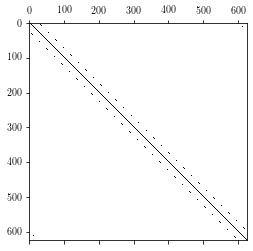

In [6]:
# Initalise FDM
FDM = np.zeros((N*N,N*N), dtype=complex)

# Assemble row entries for each region
for r in range(4):
    RegionalFDM(FDM, r+1, N, theta, log=False)

# Assemble row entries for each horizontal edge
for he in [23,34]:
    HorEdgeFDM(FDM, he, N, theta, log=False)

# Assemble row entries for each vertical edge
for ve in [31,53]:
    VerEdgeFDM(FDM, ve, N, theta, log=False)
    
# Assemble row entry for v_3
v3FDM(FDM, alpha3, N, log=False)
    
# What did we get?
plt.spy(FDM)
plt.show()

## Analysing the FDM

The matrix $M=$ `FDM` is our discretised form of the operator that defines our equations above.
The system
\begin{align*}
    M U = \omega^2 U,
\end{align*}
when $\alpha_3\neq 0$ is the discretised form of the above equation.
When $\alpha_3 = 0$, we have to use a trick to ensure that we are still solving this system and introduce the function $\beta(\omega^2)$ which is defined as

\begin{align*}
    \beta:\mathbb{C}\rightarrow\mathbb{C}^2,  \qquad
    \left( \beta(z) \right)_{jk} = (\delta_{j,k} - \delta_{N//2, N//2})z.
\end{align*}
Essentially, zero-out the entry corresponding to $u(v_3)$.
Also define $B = \beta(z)/z$ to be the constant matrix, which is just the identity matrix with 0 on the diagonal in the position corresponding to the vertex v_3.
Also, there is actually no reason for us to assume that the eigenvalues are entirely real (at least for the time being, since I don't know if the FDM is even Hermitian either), so using $z$ here makes more sense.
Then the system above is discretised into
\begin{align*}
    M U = \beta(z) U = z B U,
\end{align*}
which can be solved by a generalised eigenvalue solver.

In [7]:
def B(N):
    '''
    Constructs the matrix B defined above.
    INPUTS:
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        B: (N*N,N*N) complex, defined above.
    '''
    
    B = np.eye(N*N, dtype=complex)
    row = M2C(N//2, N//2)
    B[row, row] = 0. + 0.j
    return B

def Beta(z, N):
    '''
    Evaluates the matrix \beta defined above.
    Note that the argument is just z, so use the convention z = omega^2 here.
    INPUTS:
        z: complex, z=omega^2.
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        beta: (N*N,N*N) complex, defined above and evaluated at z.
    '''
    
    return z * gamma(N)

With these functions defined, we can now try and find some eigenfunctions!
We'll look at the $\alpha_3=0$ case first, since that's the one we know how to derive.
To find the eigenvalues, we'll need to use SciPy's `eig` function here, and pass in the matrix $B$.

In [8]:
# scipy.linalg.eig(a, b=None, left=False, right=True, ...
# overwrite_a=False, overwrite_b=False, check_finite=True, homogeneous_eigvals=False)

# Solves a vr = w b vr, for SQUARE matrices a, b. Returns eVals w and eVecs vr (stored column-wise)

wVals, wVecs = eig(FDM, B(N))

19
Number of contour levels exceeds or equals N!


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


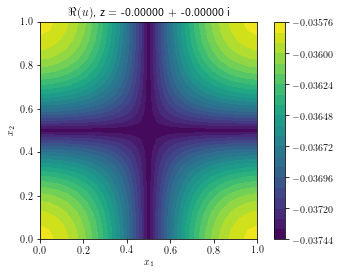

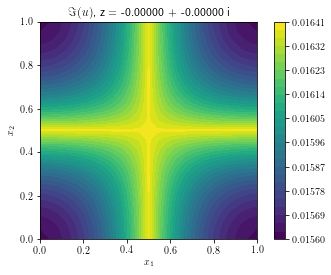

In [9]:
#for w in range(len(wVecs)//N):
wMin = np.argmin(np.abs(np.real(wVals)))
print(wMin)

for w in [wMin]:
    z = wVals[w]
    U = wVecs[:,w]
    fr, fi = PlotFn(N, U, N)
    fr[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
    fi[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
    fr[0].show()
    fi[0].show()